### Анализ данных компании, которая разрабатывает мобильные игры. В первую очередь, нас интересует показатель retention. Нужно написать функцию для его подсчета.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reg_data = pd.read_csv('shared/problem1-reg_data.csv', sep=';')  # исходные данные о времени регистрации пользователей

In [3]:
auth_data = pd.read_csv('shared/problem1-auth_data.csv', sep=';')  # исходные данные о времени захода пользователей в игру

**Предварительный анализ данных**

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Данные о времени регистрации и авторизации представлены в формате UNIX time, необходимо преобразование форматов данных:

In [6]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')

In [7]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [8]:
reg_data.isna().sum()  # проверка на наличие отсутствующих значений

reg_ts    0
uid       0
dtype: int64

In [9]:
auth_data.isna().sum()  # проверка на наличие отсутствующих значений

auth_ts    0
uid        0
dtype: int64

In [10]:
reg_data[reg_data.duplicated()]  # проверка на наличие дубликатов

,reg_ts,uid


In [11]:
auth_data[auth_data.duplicated()]  # проверка на наличие дубликатов

,auth_ts,uid


In [12]:
min_data = reg_data.reg_ts.min()  # временной диапазон исходных данных о регистрации пользователей
max_data = reg_data.reg_ts.max()

**Подготовка исходного датасета**

У каждого игрока есть одна дата регистрации и несколько дат авторизации. С помощью left join объединим таблицы.

In [13]:
df = reg_data.merge(auth_data, on='uid', how='left')

In [14]:
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


### **Решение задачи. Расчет Retention (по дням от даты регистрации игрока)**

Так как Retention будем считать по дням, то преобразуем данные о времени регистрации и авторизации пользователей в формат только даты (без указания времени)

In [15]:
df['reg_ts'] = pd.to_datetime(df['reg_ts']).dt.date
df['auth_ts'] = pd.to_datetime(df['auth_ts']).dt.date

In [16]:
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


Функция retention на вход принимает подготовленный датасет, дату начала и дату окончания исследуемого периода, а также требуемое для анализа количество дней от даты регистрации (N-day retention). Когорты соответствуют дням регистрации пользователей.

In [17]:
# Ограничения по датам:
f'минимальная дата регистрации игрока: {min_data}, '  f'максимальная дата регистрации игрока: {max_data}'

'минимальная дата регистрации игрока: 1998-11-18 09:43:43, максимальная дата регистрации игрока: 2020-09-23 15:17:24'

In [18]:
# Задаем исходные параметры с учетом ограничений временного диапазона
period_begin = '2020-01-01'
period_end = '2020-02-01'
n_day = 7

In [19]:
def retention(df, period_begin, period_end, n_day):  # функция для расчета retention
    pd.options.mode.chained_assignment = None

    # переводим даты начала и окончания периода в соответствующий формат
    begin = pd.to_datetime(period_begin).date()
    end = pd.to_datetime(period_end).date()
    min_data = df.reg_ts.min()
    max_data = df.reg_ts.max()
    
    # проверка корректности введенных дат
    if begin < min_data or begin > max_data:
        print('Начальная дата не соответствует диапазону')
    elif end < min_data or end > max_data:
        print('Конечная дата не соответствует диапазону')
    elif end < begin:
        print('Конечная дата меньше начальной')
    else:    
        
        # выберем данные за заданный период
        df2 = df.loc[((df.reg_ts >= begin) & (df.reg_ts <= end)), :]

        # добавляем столбец с кол-вом дней от регистрации до авторизации
        df2['time_diff'] = (df2['auth_ts'] - df['reg_ts']).dt.days
        
        # проверка корректности введеного значения N-day 
        if n_day > df2.time_diff.max():
            print('значение N-day не соответствует выбранному диапазону')
        else:  
        
            # когорта = день регистрации
            # рассчитываем количество пользователей для каждой когорты за промежутки времени от регистрации до авторизации
            df_cohorts = df2.groupby(['reg_ts', 'time_diff'], as_index = False) \
                            .agg({'uid' : pd.Series.nunique}) \
                            .rename(columns={'uid':'number_of_users'})

            # отдельный столбец с количеством пользователей на старте каждой когорты
            df_first_day_cohort = df2.groupby('reg_ts', as_index = False)\
                                     .agg({'uid': pd.Series.nunique})\
                                     .rename(columns={'uid':'first_day_users'})

            # объединяем столбец с основным датафрэймом
            df_cohorts = df_cohorts.merge(df_first_day_cohort, on='reg_ts', how='left')

            # в отдельном столбце рассчитываем коэффициент retention
            df_cohorts['retention'] = round(df_cohorts['number_of_users'] / df_cohorts['first_day_users'], 4)

            # строим сводную таблицу
            df_cohorts_pivot = df_cohorts.pivot(index='reg_ts', columns='time_diff', values='retention')
            df_cohorts_nday = df_cohorts_pivot.iloc[:, 0:n_day + 1]

            # график для наглядности 
            plt.figure(figsize=(20,20))
            ax = sns.heatmap(df_cohorts_nday, annot=True, cmap='Reds', fmt='.2%', vmin=0, vmax=0.2)
            ax.xaxis.tick_top()
            plt.xlabel('N-day Retention')
            plt.ylabel('Когорта')
            plt.title('Когортный анализ пользователей', pad=40)
            plt.yticks(rotation=0)
            plt.show()

            return df_cohorts_nday



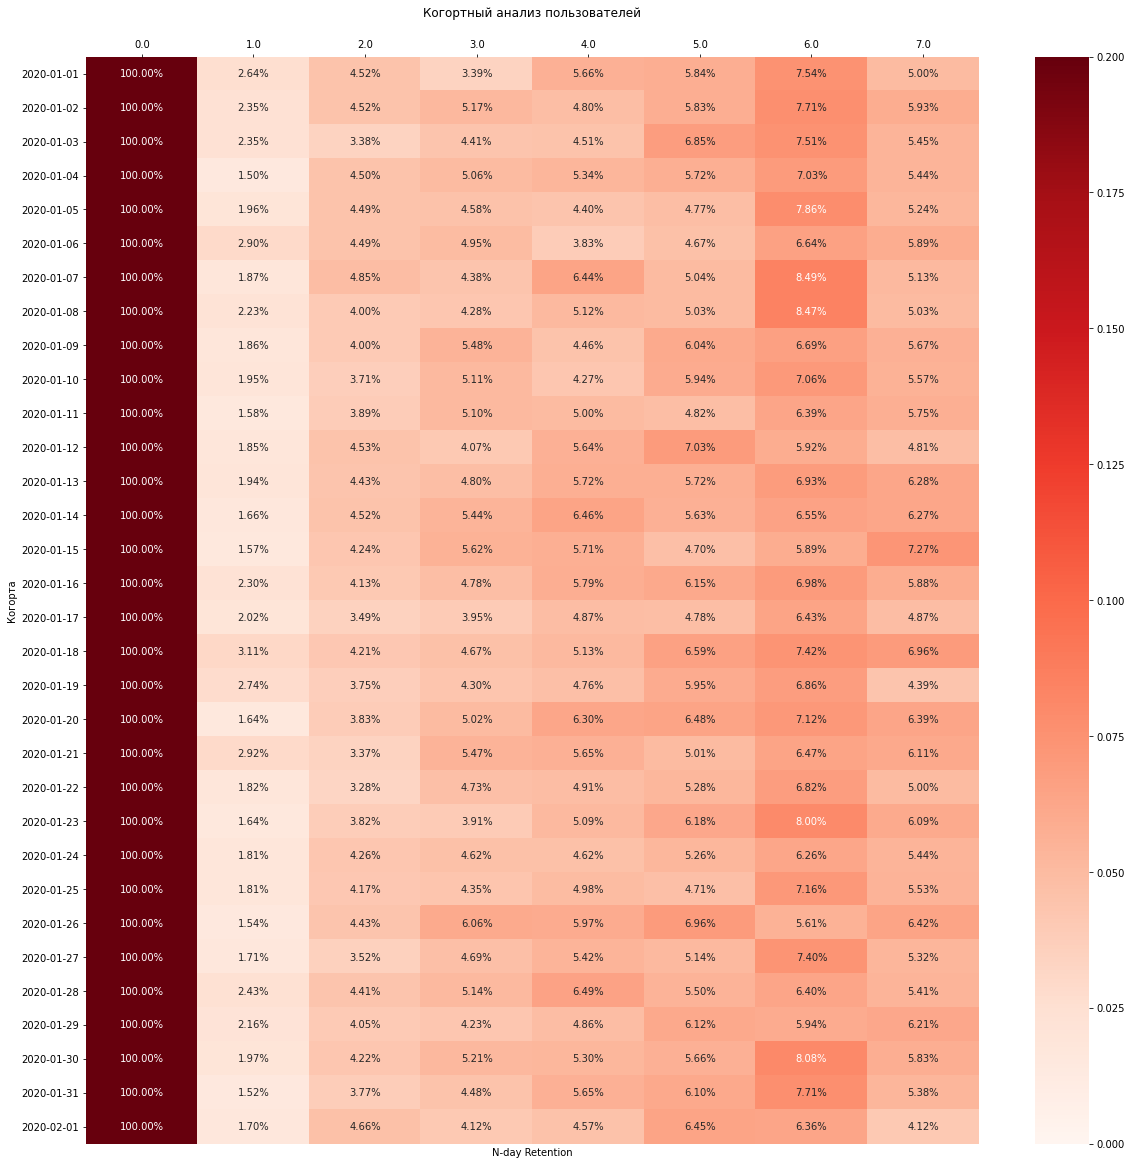

time_diff,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
reg_ts,,,,,,,,
2020-01-01,1.0,0.0264,0.0452,0.0339,0.0566,0.0584,0.0754,0.0500
2020-01-02,1.0,0.0235,0.0452,0.0517,0.0480,0.0583,0.0771,0.0593
2020-01-03,1.0,0.0235,0.0338,0.0441,0.0451,0.0685,0.0751,0.0545
2020-01-04,1.0,0.0150,0.0450,0.0506,0.0534,0.0572,0.0703,0.0544
2020-01-05,1.0,0.0196,0.0449,0.0458,0.0440,0.0477,0.0786,0.0524
2020-01-06,1.0,0.0290,0.0449,0.0495,0.0383,0.0467,0.0664,0.0589
2020-01-07,1.0,0.0187,0.0485,0.0438,0.0644,0.0504,0.0849,0.0513
2020-01-08,1.0,0.0223,0.0400,0.0428,0.0512,0.0503,0.0847,0.0503
2020-01-09,1.0,0.0186,0.0400,0.0548,0.0446,0.0604,0.0669,0.0567


In [20]:
retention(df, period_begin, period_end, n_day)  #проверка работы функции, вывод результатов